<a href="https://colab.research.google.com/github/PabRubio/pytorch-model/blob/main/pytorch_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Chicken Image Recognition Model by Pablo R.

Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader, random_split

Load and normalize data

In [ ]:
data_dir = '/content/drive/My Drive/dataset'

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 4
num_workers = 2

full_dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

trainloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

classes = full_dataset.classes
print('Classes:', classes)

Classes: ['chicken', 'not-chicken']


Visualize images

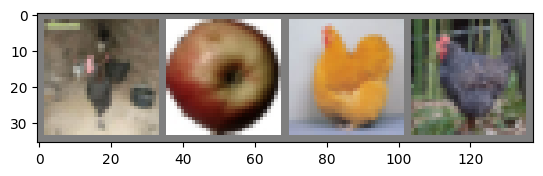

chicken not-chicken chicken chicken


In [ ]:
def imshow(img):
    """ function to show image """
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

print(' '.join('%s' % classes[labels[j]] for j in range(batch_size)))

Define the CNN

In [ ]:
class Net(nn.Module):
    """ Models a simple Convolutional Neural Network """

    def __init__(self):
        """ Initialize the network """
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        """ The forward propagation algorithm """
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Define a Loss function and optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Check if GPU is available

In [ ]:
if torch.cuda.is_available():
    print('GPU is available')
    device = torch.device("cuda")
else:
    print('GPU not available, using CPU')
    device = torch.device('cpu')

GPU is available


Train the network

In [ ]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

for epoch in range(3):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

end.record()

torch.cuda.synchronize()

print('Finished Training')
print(start.elapsed_time(end))

Finished Training


Save neural network

In [ ]:
PATH = './chicken_net.pth'
torch.save(net.state_dict(), PATH)

net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Test the network on test data

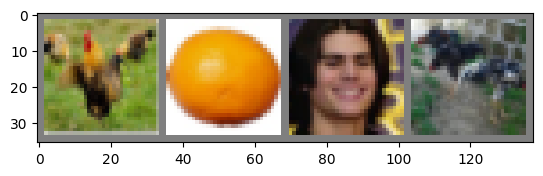

GroundTruth:  chicken not-chicken not-chicken chicken


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%s' % classes[labels[j]] for j in range(4)))

In [ ]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  chicken not-chicken not-chicken chicken
